In [39]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [40]:
train_data.shape

(404, 13)

In [41]:
test_data.shape

(102, 13)

In [42]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneousdata, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in Numpy.
-----

In [43]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Because so few samples are available, you’ll use a very small network with two hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting.
----

In [44]:
from keras import models
from keras import layers

def build_model() :
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

K-fold cross-validation.It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.
----

In [47]:
import numpy as np
k=4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [48]:



for i in range(k):
  
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1)*num_val_samples:]],axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
         axis=0)
    
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
           epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [49]:
all_scores

[2.012641668319702, 2.355055332183838, 2.8937370777130127, 2.4875094890594482]

In [50]:
np.mean(all_scores)

2.4372358918190002

The different runs do indeed show rather different validation scores, from 2.6 to 3.2.The average (3.0) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation. In this case, you’re off by $3,000 on average,
-------------------

In [56]:
# Now we are gonna train the model on longer epochs

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #' , i)
    val_data = train_data[i*num_val_samples:(i+1)* num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+ 1)* num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
               epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [59]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
average_mae_history

[4.58412629365921,
 3.333370268344879,
 3.033999025821686,
 2.9338438510894775,
 2.744952082633972,
 2.7259268164634705,
 2.6697500348091125,
 2.6693493723869324,
 2.590334117412567,
 2.5675927996635437,
 2.579347848892212,
 2.4988481998443604,
 2.4745779931545258,
 2.5066959261894226,
 2.468634307384491,
 2.4672188758850098,
 2.365894466638565,
 2.423032760620117,
 2.5631077885627747,
 2.590386211872101,
 2.3821505308151245,
 2.342450976371765,
 2.4899052381515503,
 2.39059180021286,
 2.388766348361969,
 2.4105381071567535,
 2.3909210562705994,
 2.2821898460388184,
 2.439015567302704,
 2.4415783286094666,
 2.472299635410309,
 2.3911792933940887,
 2.27318274974823,
 2.394458055496216,
 2.3665472865104675,
 2.5047637820243835,
 2.459730327129364,
 2.4393399953842163,
 2.242366224527359,
 2.249276727437973,
 2.3668033480644226,
 2.3236858248710632,
 2.394417464733124,
 2.3150908946990967,
 2.3806315064430237,
 2.234824001789093,
 2.4173194766044617,
 2.263991743326187,
 2.392448693513870

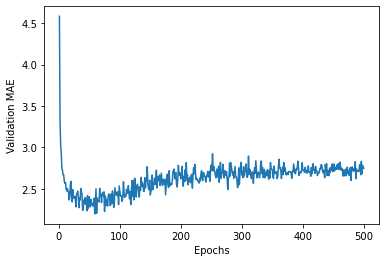

In [60]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

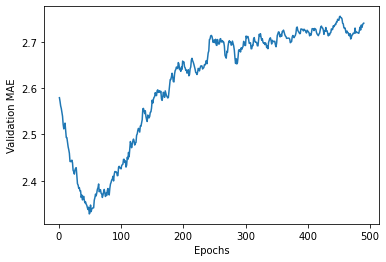

In [62]:
# Plotting validation scores, excluding the first 10 data points

def smooth_curve(points , factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs.Past that point, you start overfitting.Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the hidden layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.
------

In [64]:
model = build_model()
model.fit(train_data , train_targets,
         epochs=80, batch_size = 16 ,  verbose=0)
test_mse_score , test_mae_score = model.evaluate(test_data , test_targets)
test_mae_score

4/4 [==============================] - 0s 997us/step - loss: 18.8108 - mae: 2.7019


2.701868772506714